In [163]:
import gzip

# Caricamento del dataset
samples = []
with gzip.open("dataset/wiki-RfA.txt.gz", "rt", encoding="utf-8", errors="ignore") as f:
    block = {}
    for line in f:
        line = line.strip()
        if not line:
            if "SRC" in block and "TGT" in block and "VOT" in block:
                samples.append((block["SRC"], block["TGT"], int(block["VOT"])))
            block = {}
        else:
            key, value = line.split(":", 1)
            block[key] = value.strip()

print(f"Campioni totali: {len(samples)}")


Campioni totali: 198275


In [164]:
from sklearn.preprocessing import LabelEncoder
import torch

# Codifica utenti come ID numerici
users = list(set([s[0] for s in samples] + [s[1] for s in samples]))
encoder = LabelEncoder()
user_ids = encoder.fit_transform(users)
user_map = dict(zip(users, user_ids))




## Link score prediction ##

In [165]:
# Costruisci dataset
X = []
y = []
for src, tgt, vot in samples:
    if src in user_map and tgt in user_map:
        X.append([user_map[src], user_map[tgt]])
        y.append(vot)

X = torch.tensor(X, dtype=torch.long)
y = torch.tensor(y, dtype=torch.long)

In [166]:
from sklearn.model_selection import train_test_split

# Suddivisione in training e test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [167]:
import torch.nn as nn

# Modello di rete neurale per la predizione del voto
class VotePredictor(nn.Module):
    def __init__(self, num_users, emb_dim=64):
        super().__init__()
        self.emb = nn.Embedding(num_users, emb_dim)
        self.mlp = nn.Sequential(
            nn.Linear(emb_dim * 2, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 3)  # 3 classi: -1, 0, +1 → shiftate a 0,1,2
        )

    # Predizione
    def forward(self, x):
        src_emb = self.emb(x[:, 0])
        tgt_emb = self.emb(x[:, 1])
        combined = torch.cat([src_emb, tgt_emb], dim=1)
        return self.mlp(combined)


In [168]:
import torch
print("CUDA disponibile:", torch.cuda.is_available())
print("Dispositivo:", torch.cuda.get_device_name(0))
print("Memoria allocata:", torch.cuda.memory_allocated(0) / 1024**2, "MB")


CUDA disponibile: True
Dispositivo: NVIDIA GeForce RTX 4070
Memoria allocata: 840.1552734375 MB


In [169]:
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.functional import cross_entropy

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

model = VotePredictor(num_users=len(user_map)).to("cuda")
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(1, 100): 
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to("cuda"), yb.to("cuda")
        optimizer.zero_grad()
        out = model(xb)
        class_weights = torch.tensor([1.5, 1.0, 0.8]).to("cuda")  # penalizza di più gli Oppose
        loss = cross_entropy(out, yb + 1, weight=class_weights) # shift labels da [-1,0,1] a [0,1,2]
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch}, Loss: {total_loss:.4f}")


Epoch 1, Loss: 504.8417
Epoch 2, Loss: 425.1566
Epoch 3, Loss: 378.3770
Epoch 4, Loss: 354.5301
Epoch 5, Loss: 339.4635
Epoch 6, Loss: 328.8922
Epoch 7, Loss: 320.4751
Epoch 8, Loss: 312.4246
Epoch 9, Loss: 307.1693
Epoch 10, Loss: 301.5128
Epoch 11, Loss: 296.3410
Epoch 12, Loss: 292.1330
Epoch 13, Loss: 287.1293
Epoch 14, Loss: 282.9931
Epoch 15, Loss: 279.2843
Epoch 16, Loss: 275.7461
Epoch 17, Loss: 270.9693
Epoch 18, Loss: 268.0285
Epoch 19, Loss: 264.1456
Epoch 20, Loss: 259.7270
Epoch 21, Loss: 257.0552
Epoch 22, Loss: 254.3138
Epoch 23, Loss: 250.9923
Epoch 24, Loss: 248.5719
Epoch 25, Loss: 244.7743
Epoch 26, Loss: 242.3446
Epoch 27, Loss: 239.7771
Epoch 28, Loss: 236.1927
Epoch 29, Loss: 233.9207
Epoch 30, Loss: 232.0641
Epoch 31, Loss: 228.5756
Epoch 32, Loss: 225.6907
Epoch 33, Loss: 223.5386
Epoch 34, Loss: 221.6663
Epoch 35, Loss: 218.3994
Epoch 36, Loss: 215.8588
Epoch 37, Loss: 213.3442
Epoch 38, Loss: 211.1220
Epoch 39, Loss: 208.6214
Epoch 40, Loss: 207.6798
Epoch 41,

              precision    recall  f1-score   support

      Oppose       0.56      0.65      0.60      8237
     Neutral       0.35      0.16      0.22      2633
     Support       0.87      0.87      0.87     28785

    accuracy                           0.78     39655
   macro avg       0.59      0.56      0.56     39655
weighted avg       0.77      0.78      0.77     39655



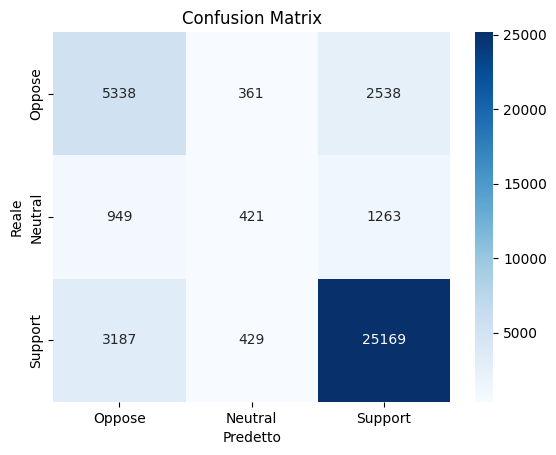

In [8]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predizioni
model.eval()
with torch.no_grad():
    X_eval = X_test.to("cuda")
    y_pred = model(X_eval).argmax(dim=1).cpu().numpy()
    y_true = (y_test + 1).numpy()  # shift da [-1,0,1] a [0,1,2]

# Report
print(classification_report(y_true, y_pred, target_names=["Oppose", "Neutral", "Support"]))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Oppose", "Neutral", "Support"],
            yticklabels=["Oppose", "Neutral", "Support"])
plt.xlabel("Predetto")
plt.ylabel("Reale")
plt.title("Confusion Matrix")
plt.show()


## Link prediction ##

In [25]:
import torch.nn as nn

# Costruzione dataset per link prediction
positive_edges = set((s[0], s[1]) for s in samples)

import random
users = list(user_map.keys())
negative_edges = set()
while len(negative_edges) < len(positive_edges):
    u1, u2 = random.sample(users, 2)
    if (u1, u2) not in positive_edges:
        negative_edges.add((u1, u2))

X_lp = []
y_lp = []

for src, tgt in positive_edges:
    X_lp.append([user_map[src], user_map[tgt]])
    y_lp.append(1)

for src, tgt in negative_edges:
    X_lp.append([user_map[src], user_map[tgt]])
    y_lp.append(0)

X_lp = torch.tensor(X_lp, dtype=torch.long)
y_lp = torch.tensor(y_lp, dtype=torch.float)

# Split
from sklearn.model_selection import train_test_split
X_lp_train, X_lp_test, y_lp_train, y_lp_test = train_test_split(X_lp, y_lp, test_size=0.2, random_state=42)

In [ ]:
# Modello
class LinkPredictor(nn.Module):
    def __init__(self, num_users, emb_dim=64):
        super().__init__()
        self.emb = nn.Embedding(num_users, emb_dim)
        self.mlp = nn.Sequential(
            nn.Linear(emb_dim * 2, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        src_emb = self.emb(x[:, 0])
        tgt_emb = self.emb(x[:, 1])
        combined = torch.cat([src_emb, tgt_emb], dim=1)
        return self.mlp(combined).squeeze()

# Training
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.functional import binary_cross_entropy

train_lp_dataset = TensorDataset(X_lp_train, y_lp_train)
train_lp_loader = DataLoader(train_lp_dataset, batch_size=256, shuffle=True)

lp_model = LinkPredictor(num_users=len(user_map)).to("cuda")
optimizer = torch.optim.Adam(lp_model.parameters(), lr=0.001)

for epoch in range(1, 21):
    lp_model.train()
    total_loss = 0
    for xb, yb in train_lp_loader:
        xb, yb = xb.to("cuda"), yb.to("cuda")
        optimizer.zero_grad()
        out = lp_model(xb)
        loss = binary_cross_entropy(out, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"[LP] Epoch {epoch}, Loss: {total_loss:.4f}")


[LP] Epoch 1, Loss: 578.5963
[LP] Epoch 2, Loss: 306.4361
[LP] Epoch 3, Loss: 245.1680
[LP] Epoch 4, Loss: 218.9460
[LP] Epoch 5, Loss: 202.6473
[LP] Epoch 6, Loss: 190.1246
[LP] Epoch 7, Loss: 179.3539
[LP] Epoch 8, Loss: 169.3808
[LP] Epoch 9, Loss: 159.3950
[LP] Epoch 10, Loss: 149.1745
[LP] Epoch 11, Loss: 139.1260
[LP] Epoch 12, Loss: 128.4637
[LP] Epoch 13, Loss: 117.3804
[LP] Epoch 14, Loss: 106.5115
[LP] Epoch 15, Loss: 95.4751
[LP] Epoch 16, Loss: 84.8152
[LP] Epoch 17, Loss: 73.9206
[LP] Epoch 18, Loss: 64.2840
[LP] Epoch 19, Loss: 54.9753
[LP] Epoch 20, Loss: 46.6911


In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

# Valutazione Link Prediction
lp_model.eval()
with torch.no_grad():
    y_lp_pred = lp_model(X_lp_test.to("cuda")).cpu().numpy()
    y_lp_true = y_lp_test.numpy()
    y_lp_bin = (y_lp_pred > 0.5).astype(int)

print(classification_report(y_lp_true, y_lp_bin))
print("ROC-AUC:", roc_auc_score(y_lp_true, y_lp_pred))


              precision    recall  f1-score   support

         0.0       0.90      0.89      0.90     37846
         1.0       0.89      0.90      0.90     37756

    accuracy                           0.90     75602
   macro avg       0.90      0.90      0.90     75602
weighted avg       0.90      0.90      0.90     75602

ROC-AUC: 0.9551949319571724


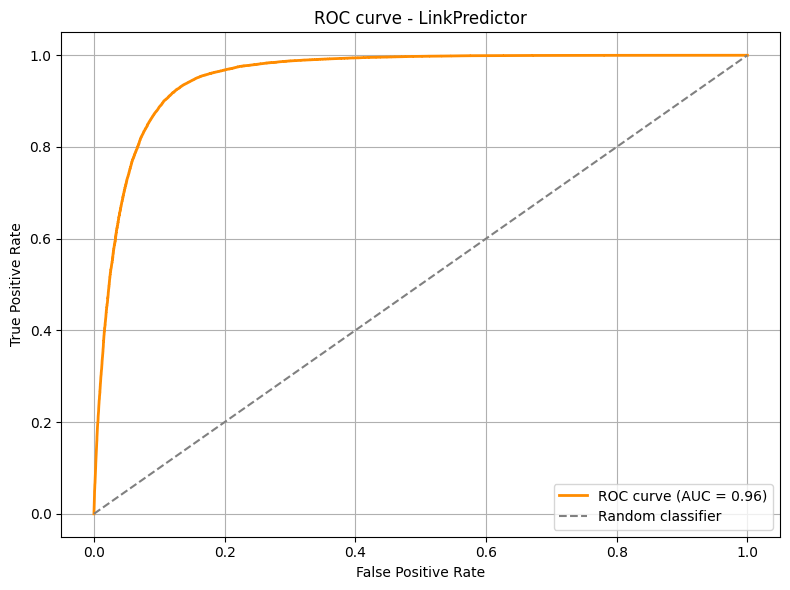

In [11]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Calcola i punti ROC
fpr, tpr, thresholds = roc_curve(y_lp_true, y_lp_pred)
auc = roc_auc_score(y_lp_true, y_lp_pred)

# Plot della curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.2f})", color="darkorange", linewidth=2)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve - LinkPredictor")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


## Clustering ##

In [12]:
# Estrai gli embedding utente
emb_matrix = lp_model.emb.weight.data.cpu().numpy()

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
emb_2d = tsne.fit_transform(emb_matrix)


In [ ]:
from sklearn.cluster import KMeans

# Clustering KMeans
n_clusters = 2 
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(emb_matrix)


In [ ]:
import matplotlib.cm as cm
import matplotlib.colors as colors

cmap = cm.get_cmap("tab10", kmeans.n_clusters)
norm = colors.Normalize(vmin=0, vmax=kmeans.n_clusters - 1)

plt.figure(figsize=(10, 8))
sc = plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=cluster_labels, cmap=cmap, norm=norm, alpha=0.7)
plt.colorbar(sc, ticks=range(kmeans.n_clusters), label="Cluster")
plt.title("t-SNE degli embedding utente con clustering K=2")
plt.xlabel("Dimensione 1")
plt.ylabel("Dimensione 2")
plt.grid(True)
plt.show()


In [15]:
from collections import defaultdict, Counter

# Conta voti dati e ricevuti per ogni utente
votes_given = defaultdict(int)
votes_received = defaultdict(int)
for src, tgt, vot in samples:
    votes_given[src] += 1
    votes_received[tgt] += 1

# Mappa cluster → utenti
cluster_map = defaultdict(list)
for i, user in enumerate(encoder.classes_):
    cluster_map[cluster_labels[i]].append(user)

# Analizza ogni cluster
for k in range(kmeans.n_clusters):
    users = cluster_map[k]
    given = [votes_given[u] for u in users]
    received = [votes_received[u] for u in users]
    print(f"Cluster {k}:")
    print(f"  Utenti: {len(users)}")
    print(f"  Voti dati (media): {sum(given)/len(users):.2f}")
    print(f"  Voti ricevuti (media): {sum(received)/len(users):.2f}")


Cluster 0:
  Utenti: 3825
  Voti dati (media): 40.71
  Voti ricevuti (media): 51.09
Cluster 1:
  Utenti: 7556
  Voti dati (media): 5.63
  Voti ricevuti (media): 0.38


In [ ]:
from collections import defaultdict, Counter

# Conta voti dati e ricevuti per ogni utente, divisi per tipo
votes_given_type = defaultdict(lambda: Counter({-1: 0, 0: 0, 1: 0}))
votes_received_type = defaultdict(lambda: Counter({-1: 0, 0: 0, 1: 0}))

for src, tgt, vot in samples:
    votes_given_type[src][vot] += 1
    votes_received_type[tgt][vot] += 1

# Mappa cluster → utenti
cluster_map = defaultdict(list)
for i, user in enumerate(encoder.classes_):
    cluster_map[cluster_labels[i]].append(user)

# Analizza ogni cluster
for k in range(kmeans.n_clusters):
    users = cluster_map[k]
    n = len(users)

    # Medie assolute
    pos_given = sum(votes_given_type[u][1] for u in users) / n
    neg_given = sum(votes_given_type[u][-1] for u in users) / n
    neut_given = sum(votes_given_type[u][0] for u in users) / n

    pos_received = sum(votes_received_type[u][1] for u in users) / n
    neg_received = sum(votes_received_type[u][-1] for u in users) / n
    neut_received = sum(votes_received_type[u][0] for u in users) / n

    # Percentuali normalizzate (rispetto al totale voti dati/ricevuti per utente)
    norm_pos_given = sum(
        votes_given_type[u][1] / sum(votes_given_type[u].values()) if sum(votes_given_type[u].values()) > 0 else 0
        for u in users
    ) / n
    norm_neg_given = sum(
        votes_given_type[u][-1] / sum(votes_given_type[u].values()) if sum(votes_given_type[u].values()) > 0 else 0
        for u in users
    ) / n
    norm_neut_given = sum(
        votes_given_type[u][0] / sum(votes_given_type[u].values()) if sum(votes_given_type[u].values()) > 0 else 0
        for u in users
    ) / n

    norm_pos_received = sum(
        votes_received_type[u][1] / sum(votes_received_type[u].values()) if sum(votes_received_type[u].values()) > 0 else 0
        for u in users
    ) / n
    norm_neg_received = sum(
        votes_received_type[u][-1] / sum(votes_received_type[u].values()) if sum(votes_received_type[u].values()) > 0 else 0
        for u in users
    ) / n
    norm_neut_received = sum(
        votes_received_type[u][0] / sum(votes_received_type[u].values()) if sum(votes_received_type[u].values()) > 0 else 0
        for u in users
    ) / n

    print(f"Cluster {k}:")
    print(f"  Utenti: {n}")
    print(f"  Voti dati (media): {pos_given + neg_given + neut_given:.2f}")
    print(f"    Positivi: {pos_given:.2f} ({norm_pos_given:.2%})")
    print(f"    Negativi: {neg_given:.2f} ({norm_neg_given:.2%})")
    print(f"    Neutri:   {neut_given:.2f} ({norm_neut_given:.2%})")
    print(f"  Voti ricevuti (media): {pos_received + neg_received + neut_received:.2f}")
    print(f"    Positivi: {pos_received:.2f} ({norm_pos_received:.2%})")
    print(f"    Negativi: {neg_received:.2f} ({norm_neg_received:.2%})")
    print(f"    Neutri:   {neut_received:.2f} ({norm_neut_received:.2%})")
    print()

    # Totali voti dati
    total_pos_given = sum(votes_given_type[u][1] for u in users)
    total_neg_given = sum(votes_given_type[u][-1] for u in users)
    total_neut_given = sum(votes_given_type[u][0] for u in users)
    total_given = total_pos_given + total_neg_given + total_neut_given

    print(f"  Voti dati totali: {total_given}")
    print(f"    Positivi: {total_pos_given} ({total_pos_given / total_given:.2%})")
    


Cluster 0:
  Utenti: 3825
  Voti dati (media): 40.71
    Positivi: 29.87 (61.34%)
    Negativi: 8.13 (15.66%)
    Neutri:   2.70 (4.49%)
  Voti ricevuti (media): 51.09
    Positivi: 37.55 (52.39%)
    Negativi: 10.31 (24.59%)
    Neutri:   3.24 (5.84%)

  Voti dati totali: 155704
    Positivi: 114256 (73.38%)
Cluster 1:
  Utenti: 7556
  Voti dati (media): 5.63
    Positivi: 4.00 (72.28%)
    Negativi: 1.33 (20.51%)
    Neutri:   0.31 (3.83%)
  Voti ricevuti (media): 0.38
    Positivi: 0.11 (0.89%)
    Negativi: 0.23 (3.12%)
    Neutri:   0.04 (0.34%)

  Voti dati totali: 42571
    Positivi: 30195 (70.93%)


### Grafo associato usando il k-means ###

In [ ]:
import networkx as nx

# Grafo diretto con pesi
G = nx.DiGraph()
for src, tgt, vot in samples:
    G.add_edge(src, tgt, weight=vot)


In [18]:
user_to_cluster = dict(zip(encoder.classes_, cluster_labels))

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Colormap con K colori
cmap = cm.get_cmap("tab10", kmeans.n_clusters)
node_colors = [cmap(user_to_cluster.get(node, 0)) for node in G.nodes()]


## NODE2VEC link prediction ##

In [138]:
import torch
import numpy as np
import networkx as nx
from torch_geometric.nn import Node2Vec

# Costruisci grafo diretto dai voti
G = nx.DiGraph()
for src, tgt, vot in samples:
    G.add_edge(user_map[src], user_map[tgt])  # usa ID numerici

# edge_index da grafo
edges = np.array(G.edges()).T   # shape (2, num_edges)
edge_index = torch.tensor(edges, dtype=torch.long)

# Inizializza Node2Vec (su GPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
node2vec = Node2Vec(
    edge_index,
    embedding_dim=64,
    walk_length=80,
    context_size=10,
    walks_per_node=10,
    num_negative_samples=1,
    sparse=True
).to(device)

# Loader e ottimizzatore
loader = node2vec.loader(batch_size=128, shuffle=True)
optimizer = torch.optim.SparseAdam(list(node2vec.parameters()), lr=0.01)

# Training loop Node2Vec
for epoch in range(1, 15):
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = node2vec.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch}, Loss: {total_loss:.4f}")

# Embedding finale
emb_node2vec = node2vec.embedding.weight.data.cpu().numpy()


Epoch 1, Loss: 218.0316
Epoch 2, Loss: 98.9589
Epoch 3, Loss: 73.1229
Epoch 4, Loss: 67.8791
Epoch 5, Loss: 66.3488
Epoch 6, Loss: 65.6985
Epoch 7, Loss: 65.3824
Epoch 8, Loss: 65.2090
Epoch 9, Loss: 65.0760
Epoch 10, Loss: 65.0008
Epoch 11, Loss: 64.9558
Epoch 12, Loss: 64.9192
Epoch 13, Loss: 64.8951
Epoch 14, Loss: 64.8678


In [147]:
import torch.nn as nn
import torch

class Node2VecLinkPredictor(nn.Module):
    def __init__(self, num_users, emb_dim=64, emb_matrix=None):
        super().__init__()
        if emb_matrix is not None:
            # Inizializza con embedding Node2Vec pre‑calcolati
            self.emb = nn.Embedding.from_pretrained(
                torch.tensor(emb_matrix, dtype=torch.float),
                freeze=False   # False = può aggiornare durante training
            )
        else:
            # Fallback: embedding random
            self.emb = nn.Embedding(num_users, emb_dim)

        self.mlp = nn.Sequential(
            nn.Linear(emb_dim * 2, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        src_emb = self.emb(x[:, 0])
        tgt_emb = self.emb(x[:, 1])
        combined = torch.cat([src_emb, tgt_emb], dim=1)
        return self.mlp(combined).squeeze()


In [148]:
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.nn.functional import binary_cross_entropy

# Split train/val/test per link prediction
X_lp_train, X_lp_temp, y_lp_train, y_lp_temp = train_test_split(
    X_lp, y_lp, test_size=0.3, random_state=42
)
X_lp_val, X_lp_test, y_lp_val, y_lp_test = train_test_split(
    X_lp_temp, y_lp_temp, test_size=0.5, random_state=42
)

train_lp_dataset = TensorDataset(X_lp_train, y_lp_train)
val_lp_dataset   = TensorDataset(X_lp_val, y_lp_val)

train_lp_loader = DataLoader(train_lp_dataset, batch_size=256, shuffle=True)
val_lp_loader   = DataLoader(val_lp_dataset, batch_size=256)

# Inizializza modello
lp_model = Node2VecLinkPredictor(
    num_users=len(user_map),
    emb_dim=64,
    emb_matrix=emb_node2vec
).to("cuda")

optimizer = torch.optim.Adam(lp_model.parameters(), lr=0.001)

# Early stopping
best_val_loss = float("inf")
patience, patience_counter = 5, 0

for epoch in range(1, 21):
    lp_model.train()
    total_loss = 0
    for xb, yb in train_lp_loader:
        xb, yb = xb.to("cuda"), yb.to("cuda").float()
        optimizer.zero_grad()
        out = lp_model(xb)
        loss = binary_cross_entropy(out, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"[Node2Vec LP] Epoch {epoch}, Train Loss: {total_loss:.4f}")

    # Validazione
    lp_model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_lp_loader:
            xb, yb = xb.to("cuda"), yb.to("cuda").float()
            out = lp_model(xb)
            val_loss += binary_cross_entropy(out, yb).item()
    val_loss /= len(val_lp_loader)
    print(f"[Node2Vec LP] Epoch {epoch}, Val Loss: {val_loss:.4f}")

    # Early stopping senza salvataggio
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break



[Node2Vec LP] Epoch 1, Train Loss: 257.0421
[Node2Vec LP] Epoch 1, Val Loss: 0.1723
[Node2Vec LP] Epoch 2, Train Loss: 140.6650
[Node2Vec LP] Epoch 2, Val Loss: 0.1513
[Node2Vec LP] Epoch 3, Train Loss: 104.9660
[Node2Vec LP] Epoch 3, Val Loss: 0.1523
[Node2Vec LP] Epoch 4, Train Loss: 83.3279
[Node2Vec LP] Epoch 4, Val Loss: 0.1641
[Node2Vec LP] Epoch 5, Train Loss: 68.3260
[Node2Vec LP] Epoch 5, Val Loss: 0.1781
[Node2Vec LP] Epoch 6, Train Loss: 56.5185
[Node2Vec LP] Epoch 6, Val Loss: 0.1974
[Node2Vec LP] Epoch 7, Train Loss: 47.0299
[Node2Vec LP] Epoch 7, Val Loss: 0.2193
Early stopping triggered


In [149]:
from sklearn.metrics import classification_report, roc_auc_score

# Valutazione Link Prediction con Node2VecLinkPredictor
lp_model.eval()
with torch.no_grad():
    # Predizioni sul test set
    y_lp_pred = lp_model(X_lp_test.to("cuda")).cpu().numpy()
    y_lp_true = y_lp_test.numpy()
    # Binarizza le predizioni (threshold 0.5)
    y_lp_bin = (y_lp_pred > 0.5).astype(int)

# Report di classificazione
print(classification_report(y_lp_true, y_lp_bin, target_names=["NoLink", "Link"]))

# ROC-AUC
print("ROC-AUC:", roc_auc_score(y_lp_true, y_lp_pred))


              precision    recall  f1-score   support

      NoLink       0.95      0.94      0.94     28545
        Link       0.94      0.94      0.94     28156

    accuracy                           0.94     56701
   macro avg       0.94      0.94      0.94     56701
weighted avg       0.94      0.94      0.94     56701

ROC-AUC: 0.9842927012679227


## NODE2VEC link score prediction ## 

In [142]:
import torch.nn as nn
import torch

class Node2VecLinkScorePredictor(nn.Module):
    def __init__(self, num_users, emb_dim=64, emb_matrix=None):
        super().__init__()
        if emb_matrix is not None:
            # Inizializza con embedding Node2Vec pre‑calcolati
            self.emb = nn.Embedding.from_pretrained(
                torch.tensor(emb_matrix, dtype=torch.float),
                freeze=False   # False = può aggiornare durante training
            )
        else:
            # Fallback: embedding random
            self.emb = nn.Embedding(num_users, emb_dim)

        self.mlp = nn.Sequential(
            nn.Linear(emb_dim * 2, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 3)  # 3 classi: Oppose (-1), Neutral (0), Support (+1)
        )

    def forward(self, x):
        src_emb = self.emb(x[:, 0])
        tgt_emb = self.emb(x[:, 1])
        combined = torch.cat([src_emb, tgt_emb], dim=1)
        return self.mlp(combined)


In [145]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from torch.nn.functional import cross_entropy

# Split train/val/test
X_train_split, X_temp, y_train_split, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

train_dataset = TensorDataset(X_train_split, y_train_split)
val_dataset   = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=256)

lp_score_model = Node2VecLinkScorePredictor(
    num_users=len(user_map),
    emb_dim=64,
    emb_matrix=emb_node2vec   # embedding Node2Vec GPU
).to("cuda")

optimizer = torch.optim.Adam(lp_score_model.parameters(), lr=0.001)

# Early stopping setup
best_val_loss = float("inf")
patience, patience_counter = 5, 0

for epoch in range(1, 100):
    lp_score_model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to("cuda"), yb.to("cuda")
        optimizer.zero_grad()
        out = lp_score_model(xb)
        loss = cross_entropy(out, yb + 1)  # shift labels
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"[Node2Vec LinkScore] Epoch {epoch}, Train Loss: {total_loss:.4f}")

    # Validazione
    lp_score_model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to("cuda"), yb.to("cuda")
            out = lp_score_model(xb)
            val_loss += cross_entropy(out, yb + 1).item()
    val_loss /= len(val_loader)
    print(f"[Node2Vec LinkScore] Epoch {epoch}, Val Loss: {val_loss:.4f}")

    # Early stopping senza salvataggio
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break



[Node2Vec LinkScore] Epoch 1, Train Loss: 336.6679
[Node2Vec LinkScore] Epoch 1, Val Loss: 0.5156
[Node2Vec LinkScore] Epoch 2, Train Loss: 262.9396
[Node2Vec LinkScore] Epoch 2, Val Loss: 0.4979
[Node2Vec LinkScore] Epoch 3, Train Loss: 243.6411
[Node2Vec LinkScore] Epoch 3, Val Loss: 0.4954
[Node2Vec LinkScore] Epoch 4, Train Loss: 231.0106
[Node2Vec LinkScore] Epoch 4, Val Loss: 0.5009
[Node2Vec LinkScore] Epoch 5, Train Loss: 221.6960
[Node2Vec LinkScore] Epoch 5, Val Loss: 0.5101
[Node2Vec LinkScore] Epoch 6, Train Loss: 213.7001
[Node2Vec LinkScore] Epoch 6, Val Loss: 0.5205
[Node2Vec LinkScore] Epoch 7, Train Loss: 206.2178
[Node2Vec LinkScore] Epoch 7, Val Loss: 0.5334
[Node2Vec LinkScore] Epoch 8, Train Loss: 200.3924
[Node2Vec LinkScore] Epoch 8, Val Loss: 0.5429
Early stopping triggered


              precision    recall  f1-score   support

      Oppose       0.64      0.60      0.62      6115
     Neutral       0.40      0.14      0.21      2017
     Support       0.86      0.93      0.89     21610

    accuracy                           0.80     29742
   macro avg       0.63      0.55      0.57     29742
weighted avg       0.78      0.80      0.79     29742



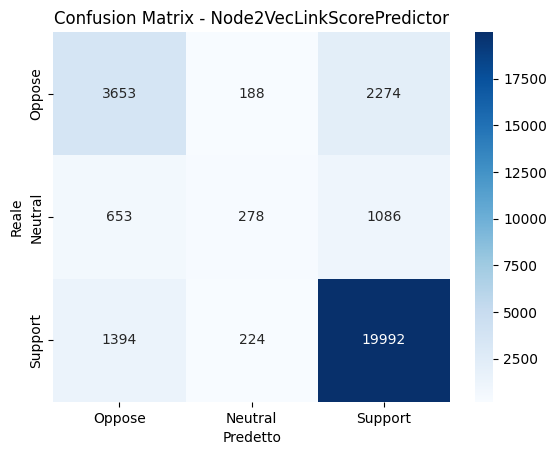

In [146]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Valutazione Node2VecLinkScorePredictor (modello già in memoria)
lp_score_model.eval()
with torch.no_grad():
    X_eval = X_test.to("cuda")
    y_pred = lp_score_model(X_eval).argmax(dim=1).cpu().numpy()
    y_true = (y_test + 1).numpy()  # shift da [-1,0,1] a [0,1,2]

# Report di classificazione
print(classification_report(y_true, y_pred, target_names=["Oppose", "Neutral", "Support"]))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Oppose", "Neutral", "Support"],
            yticklabels=["Oppose", "Neutral", "Support"])
plt.xlabel("Predetto")
plt.ylabel("Reale")
plt.title("Confusion Matrix - Node2VecLinkScorePredictor")
plt.show()


 ## Con bert link score prediction ##

In [153]:
import gzip

# Caricamento del dataset
samples = []
with gzip.open("dataset/wiki-RfA.txt.gz", "rt", encoding="utf-8", errors="ignore") as f:
    block = {}
    for line in f:
        line = line.strip()
        if not line:
            if "SRC" in block and "TGT" in block and "VOT" in block:
                # aggiungi anche TXT (se presente)
                samples.append((
                    block["SRC"],
                    block["TGT"],
                    int(block["VOT"]),
                    block.get("TXT", "")   # commento testuale
                ))
            block = {}
        else:
            key, value = line.split(":", 1)
            block[key] = value.strip()

print(f"Campioni totali: {len(samples)}")


Campioni totali: 198275


In [155]:
from sklearn.preprocessing import LabelEncoder
import torch

# Codifica utenti come ID numerici
users = list(set([s[0] for s in samples] + [s[1] for s in samples]))
encoder = LabelEncoder()
user_ids = encoder.fit_transform(users)
user_map = dict(zip(users, user_ids))

# Costruzione X, y, texts
X, y, texts = [], [], []
for src, tgt, vot, txt in samples:
    if src in user_map and tgt in user_map:
        X.append([user_map[src], user_map[tgt]])
        y.append(vot)
        texts.append(txt if txt.strip() else "[UNK]")

X = torch.tensor(X, dtype=torch.long)
y = torch.tensor(y, dtype=torch.long)


In [156]:
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased").to("cuda")

def encode_texts(texts, batch_size=32):
    all_embs = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(batch, padding=True, truncation=True, return_tensors="pt")
        inputs = {k: v.to("cuda") for k,v in inputs.items()}
        with torch.no_grad():
            outputs = bert_model(**inputs)
        embs = outputs.last_hidden_state[:,0,:].cpu()  # CLS token
        all_embs.append(embs)
    return torch.cat(all_embs, dim=0)


In [ ]:
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# Split su X, y e testi raw
X_train, X_temp, y_train, y_temp, texts_train_raw, texts_temp_raw = train_test_split(
    X, y, texts, test_size=0.3, random_state=42
)
X_val, X_test, y_val, y_test, texts_val_raw, texts_test_raw = train_test_split(
    X_temp, y_temp, texts_temp_raw, test_size=0.66, random_state=42
)



In [ ]:
# Calcola embedding BERT per train, val e test
texts_train = encode_texts(texts_train_raw)
texts_val   = encode_texts(texts_val_raw)
texts_test  = encode_texts(texts_test_raw)


In [159]:
# Dataset e DataLoader
train_dataset = TensorDataset(X_train, y_train, texts_train)
val_dataset   = TensorDataset(X_val, y_val, texts_val)
train_loader  = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader    = DataLoader(val_dataset, batch_size=256)

In [130]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class HybridLinkScorePredictor(nn.Module):
    def __init__(self, num_users, node_emb_dim=64, text_emb_dim=768, hidden_dim=256):
        super().__init__()
        self.user_emb = nn.Embedding(num_users, node_emb_dim)
        self.fc1 = nn.Linear(node_emb_dim*2 + text_emb_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 3)
        self.unk_text_emb = nn.Parameter(torch.zeros(1, text_emb_dim))

    def forward(self, x, text_emb=None):
        src, tgt = x[:,0], x[:,1]
        src_emb = self.user_emb(src)
        tgt_emb = self.user_emb(tgt)
        if text_emb is None:
            text_emb = self.unk_text_emb.repeat(src_emb.size(0), 1)
        h = torch.cat([src_emb, tgt_emb, text_emb], dim=1)
        h = F.relu(self.fc1(h))
        return self.fc2(h)


In [160]:
import torch.optim as optim

model = HybridLinkScorePredictor(num_users=len(user_map)).to("cuda")
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
loss_fn = nn.CrossEntropyLoss()

best_val_loss = float("inf")
patience, patience_counter = 5, 0

for epoch in range(30):
    model.train()
    total_loss = 0
    for xb, yb, tb in train_loader:
        xb, yb, tb = xb.to("cuda"), yb.to("cuda"), tb.to("cuda")
        optimizer.zero_grad()
        out = model(xb, text_emb=tb)
        loss = loss_fn(out, yb + 1)  # shift labels da [-1,0,1] a [0,1,2]
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Train Loss={total_loss:.4f}")

    # Validazione
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb, tb in val_loader:
            xb, yb, tb = xb.to("cuda"), yb.to("cuda"), tb.to("cuda")
            out = model(xb, text_emb=tb)
            val_loss += loss_fn(out, yb + 1).item()
    val_loss /= len(val_loader)
    print(f"Epoch {epoch+1}, Val Loss={val_loss:.4f}")

    # Early stopping senza salvataggio
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break


Epoch 1, Train Loss=182.3457
Epoch 1, Val Loss=0.2616
Epoch 2, Train Loss=129.9679
Epoch 2, Val Loss=0.2303
Epoch 3, Train Loss=115.2691
Epoch 3, Val Loss=0.2007
Epoch 4, Train Loss=101.8749
Epoch 4, Val Loss=0.1846
Epoch 5, Train Loss=90.1237
Epoch 5, Val Loss=0.1857
Epoch 6, Train Loss=81.8824
Epoch 6, Val Loss=0.1668
Epoch 7, Train Loss=75.6519
Epoch 7, Val Loss=0.1721
Epoch 8, Train Loss=70.3203
Epoch 8, Val Loss=0.1712
Epoch 9, Train Loss=67.3338
Epoch 9, Val Loss=0.1804
Epoch 10, Train Loss=63.3275
Epoch 10, Val Loss=0.1662
Epoch 11, Train Loss=59.7348
Epoch 11, Val Loss=0.2195
Epoch 12, Train Loss=57.6877
Epoch 12, Val Loss=0.1828
Epoch 13, Train Loss=53.3011
Epoch 13, Val Loss=0.1781
Epoch 14, Train Loss=51.0597
Epoch 14, Val Loss=0.1645
Epoch 15, Train Loss=48.8433
Epoch 15, Val Loss=0.1693
Epoch 16, Train Loss=47.5455
Epoch 16, Val Loss=0.1886
Epoch 17, Train Loss=44.0639
Epoch 17, Val Loss=0.1763
Epoch 18, Train Loss=42.1598
Epoch 18, Val Loss=0.1808
Epoch 19, Train Loss=41.

              precision    recall  f1-score   support

      Oppose       0.49      0.41      0.45      8171
     Neutral       0.14      0.24      0.18      2606
     Support       0.83      0.82      0.82     28482

    accuracy                           0.69     39259
   macro avg       0.49      0.49      0.48     39259
weighted avg       0.71      0.69      0.70     39259



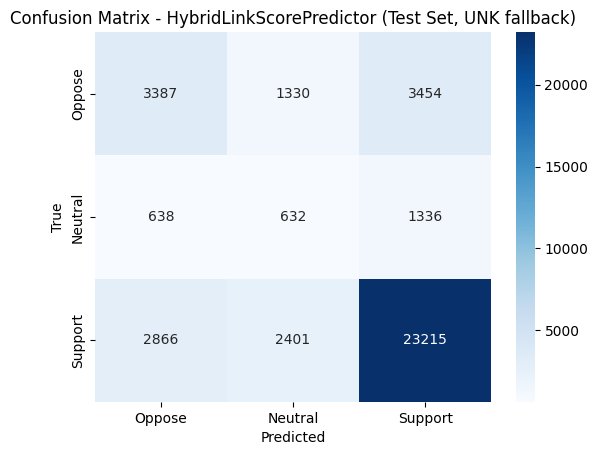

In [161]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Valutazione HybridLinkScorePredictor (modello già in memoria)
model.eval()
with torch.no_grad():
    X_eval = X_test.to("cuda")
    y_true = (y_test + 1).numpy()
    # Non passo text_emb → il modello usa self.unk_text_emb
    y_pred = model(X_eval).argmax(dim=1).cpu().numpy()

print(classification_report(y_true, y_pred, target_names=["Oppose","Neutral","Support"]))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Oppose","Neutral","Support"],
            yticklabels=["Oppose","Neutral","Support"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - HybridLinkScorePredictor (Test Set, UNK fallback)")
plt.show()


              precision    recall  f1-score   support

      Oppose       0.94      0.81      0.87      8171
     Neutral       0.70      0.71      0.71      2606
     Support       0.95      0.99      0.97     28482

    accuracy                           0.93     39259
   macro avg       0.86      0.84      0.85     39259
weighted avg       0.93      0.93      0.93     39259



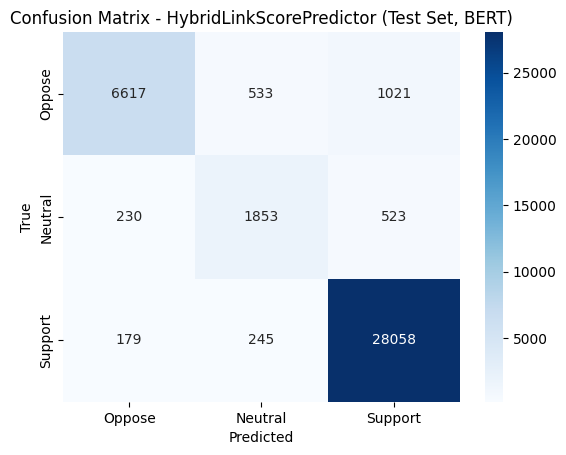

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# With bert test embeddings (this is considering cheating since the model can see test data comments)
model.eval()
with torch.no_grad():
    X_eval = X_test.to("cuda")
    y_true = (y_test + 1).numpy()
    y_pred = model(X_eval, text_emb=texts_test.to("cuda")).argmax(dim=1).cpu().numpy()

# Report di classificazione
print(classification_report(y_true, y_pred, target_names=["Oppose","Neutral","Support"]))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Oppose","Neutral","Support"],
            yticklabels=["Oppose","Neutral","Support"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - HybridLinkScorePredictor (Test Set, BERT)")
plt.show()
